In [2]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Load Precalculated Features

In [12]:
# Create a numpy array containing all the calculated features Poseformer (HRNet output)
# Exclude fields 0 (identifiers), 1 (number of cycles, duplicate), 2 (orientation), 3 (framerate)
df_calc = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/results/results-poseformer-2023-06-04.csv')
df_calc.drop(['Unnamed: 0', 'n', 'orientation', 'framerate'], axis=1, inplace=True)
df_calc

,subjectid,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,...,neck_max_y_acc_stand2sit,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand
0,kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5,5.000000,-0.083333,1.00,...,28.745159,1.592739,3.180187,1.704116,2.036679,0.915840,126.157028,163.349759,193.017009,163.114972
1,GjPHiGli,14.033333,-0.066667,0.36,0.247117,0.030709,5,5.266667,-0.791667,0.95,...,15.500082,1.627585,1.900191,1.513419,1.420853,0.918023,111.429866,128.344066,178.385573,180.138872
2,RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5,4.333333,-1.166667,1.15,...,18.362819,1.376164,1.563910,1.026070,1.518753,0.971309,96.485192,94.164582,168.988900,177.376363
3,gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5,3.900000,-0.866667,1.28,...,9.234772,1.296188,1.158777,1.313558,1.067322,0.925391,102.517993,113.330788,181.267085,214.777400
4,xEIsrkiR,12.266667,-0.500000,0.41,0.972420,0.342664,5,2.233333,-2.000000,2.24,...,30.753857,0.986963,1.307289,0.568683,0.639755,0.970054,151.456744,138.360954,201.445506,178.812067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4,5.966667,-1.311111,0.67,...,19.173748,0.831932,1.170661,0.644232,1.117247,0.956355,131.244122,104.038109,173.939678,191.231743
380,8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5,4.000000,0.100000,1.25,...,28.401683,7.196703,0.972598,3.195569,2.493561,0.954803,108.555146,147.880615,130.857804,188.354355
381,PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4,4.900000,-1.655556,0.82,...,14.930358,0.760820,0.755019,0.969426,1.280454,0.941937,100.971541,108.121823,173.023627,204.930390
382,q8FyLMSn,6.400000,0.000000,0.78,0.068638,0.042368,5,3.633333,0.175000,1.38,...,29.172789,1.067852,1.971949,1.831015,2.785638,0.920683,111.605142,178.523509,146.016761,189.715575


### Load Survey Data (labels)

In [13]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [14]:
# join the dataframes by subjectId 
df_join = df_calc.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.592739,3.180187,1.704116,2.036679,0.915840,126.157028,163.349762,193.017014,163.114975,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.627585,1.900191,1.513419,1.420853,0.918023,111.429863,128.344070,178.385574,180.138870,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,1.376164,1.563910,1.026070,1.518753,0.971309,96.485191,94.164581,168.988907,177.376358,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.296188,1.158777,1.313558,1.067322,0.925391,102.517990,113.330788,181.267090,214.777405,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.986963,1.307289,0.568683,0.639755,0.970054,151.456741,138.360947,201.445511,178.812073,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,0.831932,1.170661,0.644232,1.117247,0.956355,131.244125,104.038109,173.939682,191.231750,NaN
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,7.196703,0.972598,3.195569,2.493561,0.954803,108.555145,147.880615,130.857803,188.354355,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.760820,0.755019,0.969426,1.280454,0.941937,100.971542,108.121826,173.023621,204.930389,NaN


In [16]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.592739,3.180187,1.704116,2.036679,0.915840,126.157028,163.349762,193.017014,163.114975,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.627585,1.900191,1.513419,1.420853,0.918023,111.429863,128.344070,178.385574,180.138870,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,1.376164,1.563910,1.026070,1.518753,0.971309,96.485191,94.164581,168.988907,177.376358,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.296188,1.158777,1.313558,1.067322,0.925391,102.517990,113.330788,181.267090,214.777405,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.986963,1.307289,0.568683,0.639755,0.970054,151.456741,138.360947,201.445511,178.812073,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,0.831932,1.170661,0.644232,1.117247,0.956355,131.244125,104.038109,173.939682,191.231750,1.0
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,7.196703,0.972598,3.195569,2.493561,0.954803,108.555145,147.880615,130.857803,188.354355,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.760820,0.755019,0.969426,1.280454,0.941937,100.971542,108.121826,173.023621,204.930389,1.0


#### Data validation 

In [17]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [18]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [19]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 84
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 77% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 9

384
84.0
306
67.0
39
8.0
39
9.0


#### Create dataset

In [20]:
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

# reference: https://discuss.pytorch.org/t/dataset-from-pandas-without-folder-structure/146816/4
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.dataframe = dataframe
        self.transform = transform

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[:-1]
        label = row[-1]
        
        # reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
        if self.transform:
            features = self.transform(features)
            
        return features, label

    def __len__(self):
        return len(self.dataframe)

#### Normalization

In [21]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [22]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [24]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 448]) torch.Size([64])
tensor([[-1.0291,  0.2308,  1.0988,  ..., -0.1640,  0.4282, -0.1164],
        [ 0.0790, -0.7834, -0.2682,  ...,  0.5025, -0.1948, -0.0068],
        [-0.0845,  0.2000, -0.1494,  ..., -0.6478, -0.6494, -0.0664],
        ...,
        [-0.9564,  0.2103,  0.2072,  ..., -0.2295,  0.5424, -0.0698],
        [-1.6013,  0.2308,  2.6440,  ..., -0.2717, -0.1612,  0.1032],
        [ 1.4415, -0.5068, -1.0409,  ...,  0.1772,  0.3806,  0.5486]]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


#### Create a manually curated data set

In [25]:
df_join["time_sit2stand"]
potential_cols = df_join.filter(regex=(".*(time|speed|trunk).*")).columns.values
# for p in potential_cols:
#     print(p)
cols_manual = ['time_sit2stand',
'speed_sit2stand',
'time_sd_sit2stand',
'speed_sd_sit2stand',
'time_stand2sit',
'speed_stand2sit',
'time_sd_stand2sit',
'speed_sd_stand2sit',
'trunk_lean_range_mean',
'trunk_lean_sd',
'trunk_lean_max',
'trunk_lean_min',
'trunk_lean_ang_vel',
'trunk_lean_ang_acc',
'trunk_lean_max_ang_vel',
'trunk_lean_max_ang_acc',
'trunk_lean_min_ang_vel',
'trunk_lean_min_ang_acc',
'trunk_lean_range_mean_sit2stand',
'trunk_lean_sd_sit2stand',
'trunk_lean_max_sit2stand',
'trunk_lean_min_sit2stand',
'trunk_lean_ang_vel_sit2stand',
'trunk_lean_ang_acc_sit2stand',
'trunk_lean_max_ang_vel_sit2stand',
'trunk_lean_max_ang_acc_sit2stand',
'trunk_lean_min_ang_vel_sit2stand',
'trunk_lean_min_ang_acc_sit2stand',
'trunk_lean_range_mean_stand2sit',
'trunk_lean_sd_stand2sit',
'trunk_lean_max_stand2sit',
'trunk_lean_min_stand2sit',
'trunk_lean_ang_vel_stand2sit',
'trunk_lean_ang_acc_stand2sit',
'trunk_lean_max_ang_vel_stand2sit',
'trunk_lean_max_ang_acc_stand2sit',
'trunk_lean_min_ang_vel_stand2sit',
'trunk_lean_min_ang_acc_stand2sit',
'OA_check']
df_manual = df_join.loc[:,cols_manual]

In [26]:
# Create separate loader with manually selected columns

train_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

#### Create dataloaders with upsampling 

In [27]:
# Reference: https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dl):
        idxs = batch[0][:, 0].tolist()
        #classes = batch[0][:, 1]
        classes = batch[1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])
        else:
            raise ValueError("More than two classes detected")

    if with_outputs:
        fig, ax = plt.subplots(figsize=(2, 15), dpi=72)

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.set_xticks(range(len(dl)))
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        num_images_seen = len(idxs_seen)

        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        )
        print("=============")
        print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

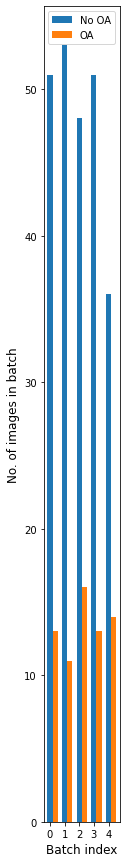

Avg Proportion of No OA per batch: 4.779999999999999
Avg Proportion of OA per batch: 1.3399999999999999
Num. unique images seen: 207/306


In [28]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

<ipython-input-29-8623099a84a5>:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  class_weights_all = class_weights[labels]


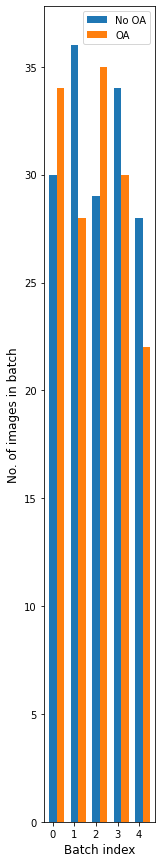

Avg Proportion of No OA per batch: 3.1399999999999997
Avg Proportion of OA per batch: 2.9799999999999995
Num. unique images seen: 138/306


In [29]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [32]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.6729, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = 0.5900, train_acc = 78.4314, val_acc = 79.4872, train_pos = 0.3268, val_pos = 0.0000
Epoch 2, loss = 0.6417, train_acc = 79.7386, val_acc = 79.4872, train_pos = 1.6340, val_pos = 0.0000
Epoch 3, loss = 0.5675, train_acc = 80.0654, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 4, loss = 0.5931, train_acc = 80.0654, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 5, loss = 0.4329, train_acc = 80.0654, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 6, loss = 0.5232, train_acc = 80.3922, val_acc = 79.4872, train_pos = 2.2876, val_pos = 0.0000
Epoch 7, loss = 0.4475, train_acc = 80.3922, val_acc = 79.4872, train_pos = 2.2876, val_pos = 0.0000
Epoch 8, loss = 0.4104, train_acc = 80.7190, val_acc = 79.4872, train_pos = 2.6144, val_pos = 0.0000
Epoch 9, loss = 0.5626, train_acc = 80.7190, val_acc = 79.4872, train_pos = 2.6144, val_pos

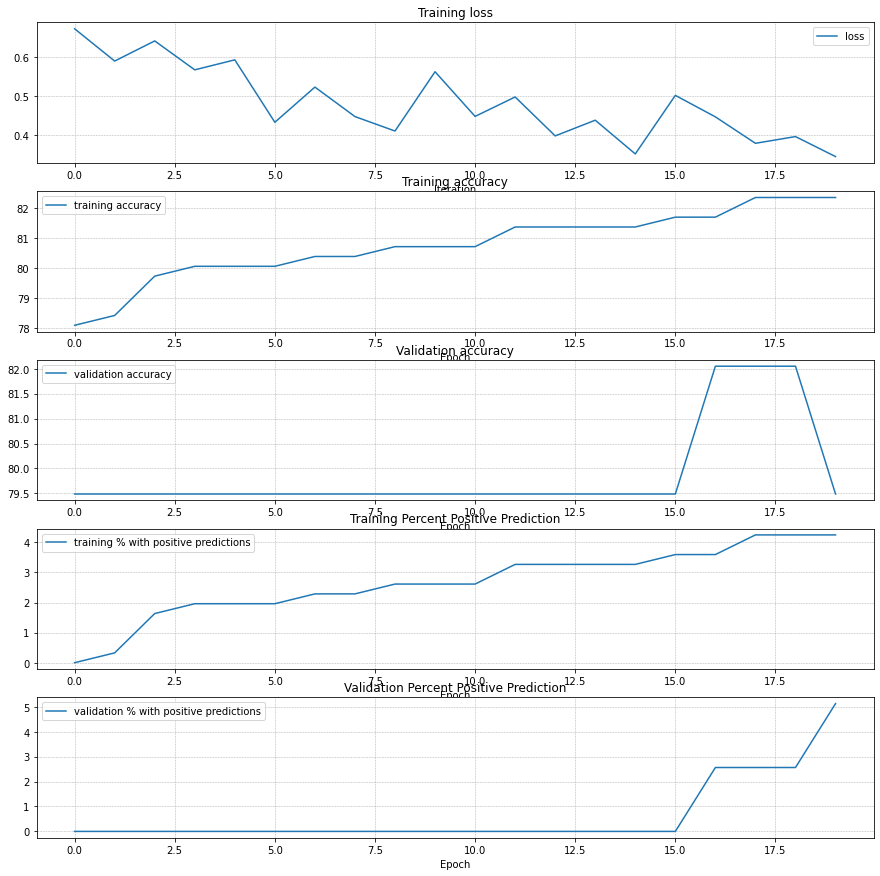

In [33]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [34]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.6628, train_acc = 54.2484, val_acc = 82.0513, train_pos = 3.5948, val_pos = 2.5641
Epoch 1, loss = 0.6147, train_acc = 57.1895, val_acc = 82.0513, train_pos = 6.8627, val_pos = 2.5641
Epoch 2, loss = 0.6512, train_acc = 57.1895, val_acc = 82.0513, train_pos = 9.4771, val_pos = 12.8205
Epoch 3, loss = 0.5707, train_acc = 60.7843, val_acc = 79.4872, train_pos = 13.7255, val_pos = 15.3846
Epoch 4, loss = 0.5695, train_acc = 70.2614, val_acc = 79.4872, train_pos = 19.2810, val_pos = 15.3846
Epoch 5, loss = 0.6005, train_acc = 77.7778, val_acc = 79.4872, train_pos = 25.8170, val_pos = 15.3846
Epoch 6, loss = 0.5933, train_acc = 76.7974, val_acc = 76.9231, train_pos = 25.8170, val_pos = 17.9487
Epoch 7, loss = 0.5594, train_acc = 72.2222, val_acc = 76.9231, train_pos = 30.7190, val_pos = 17.9487
Epoch 8, loss = 0.5652, train_acc = 76.1438, val_acc = 82.0513, train_pos = 33.6601, val_pos = 23.0769
Epoch 9, loss = 0.5043, train_acc = 75.8170, val_acc = 82.0513, train_pos = 29

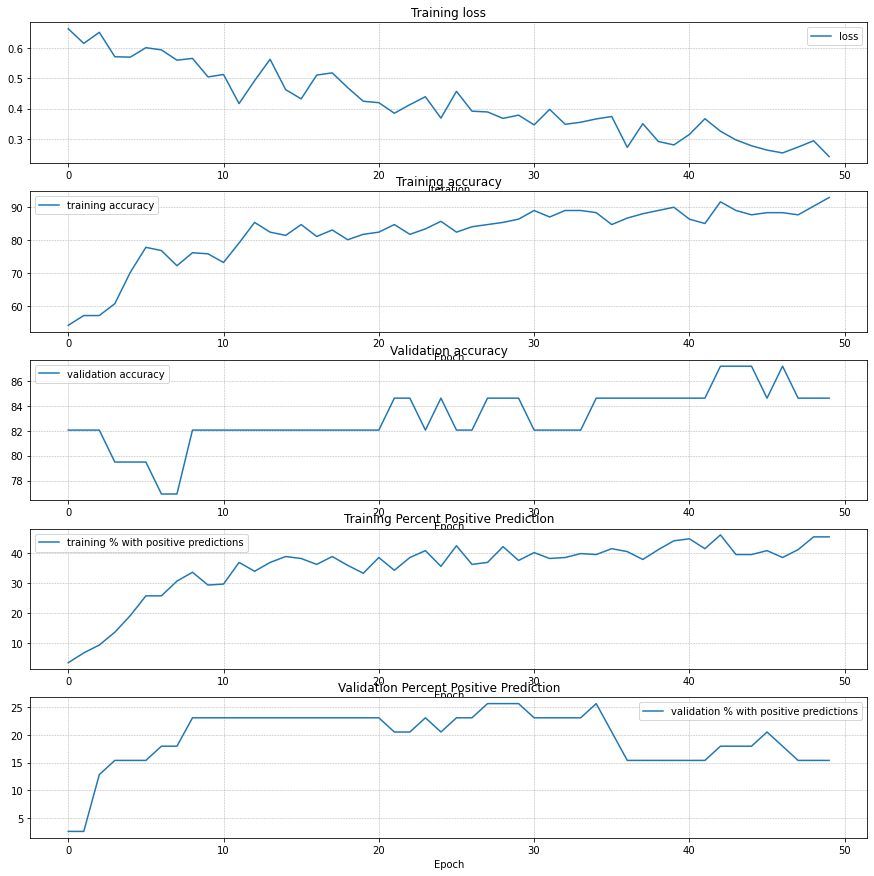

In [35]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [36]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

Epoch 0, loss = 0.6245, train_acc = 54.6025, val_acc = 79.4872, train_pos = 6.6946, val_pos = 10.2564
Epoch 1, loss = 0.5790, train_acc = 59.6234, val_acc = 79.4872, train_pos = 11.7155, val_pos = 15.3846
Epoch 2, loss = 0.5588, train_acc = 66.3180, val_acc = 79.4872, train_pos = 20.0837, val_pos = 15.3846
Epoch 3, loss = 0.6048, train_acc = 76.5690, val_acc = 79.4872, train_pos = 31.1715, val_pos = 15.3846
Epoch 4, loss = 0.5558, train_acc = 78.8703, val_acc = 79.4872, train_pos = 33.0544, val_pos = 15.3846
Epoch 5, loss = 0.5062, train_acc = 81.5900, val_acc = 82.0513, train_pos = 36.1925, val_pos = 17.9487
Epoch 6, loss = 0.5026, train_acc = 84.1004, val_acc = 84.6154, train_pos = 38.7029, val_pos = 20.5128
Epoch 7, loss = 0.5171, train_acc = 84.1004, val_acc = 82.0513, train_pos = 39.9582, val_pos = 23.0769
Epoch 8, loss = 0.4430, train_acc = 84.5188, val_acc = 82.0513, train_pos = 39.5397, val_pos = 17.9487
Epoch 9, loss = 0.4704, train_acc = 84.5188, val_acc = 82.0513, train_pos 

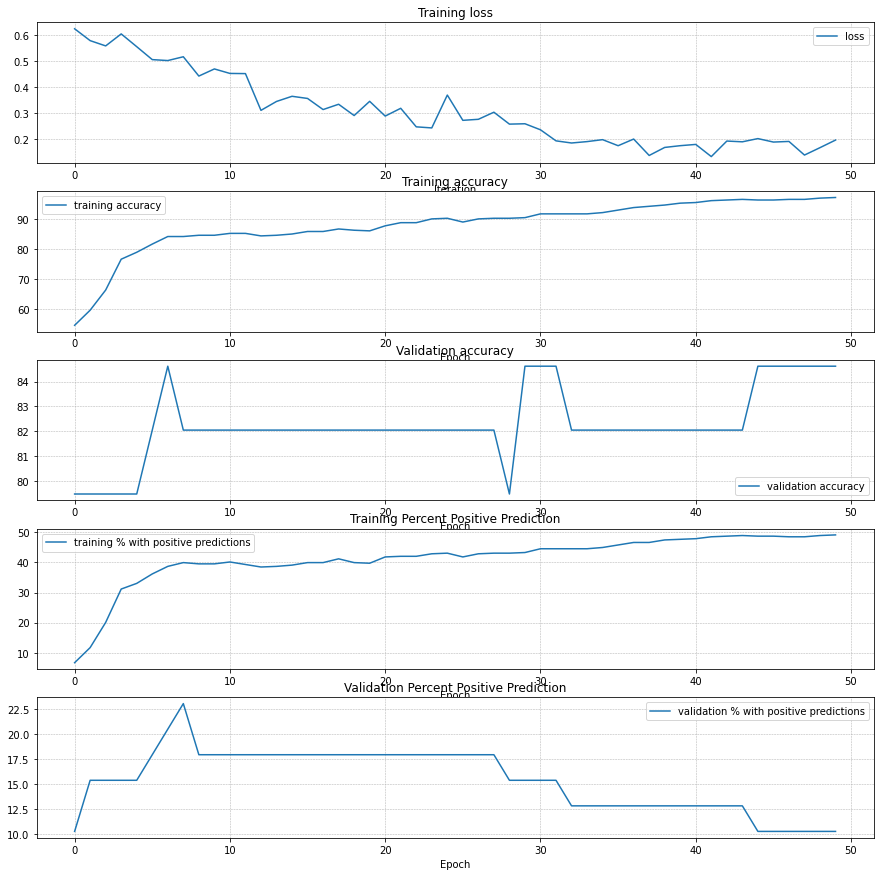

In [37]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [38]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [39]:
input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 242.6672, train_acc = 50.6536, val_acc = 76.9231, train_pos = 46.4052, val_pos = 2.5641
Epoch 1, loss = 57.3664, train_acc = 76.1438, val_acc = 74.3590, train_pos = 1.9608, val_pos = 10.2564
Epoch 2, loss = 68.5353, train_acc = 69.9346, val_acc = 53.8462, train_pos = 22.5490, val_pos = 46.1538
Epoch 3, loss = 23.8803, train_acc = 67.3203, val_acc = 69.2308, train_pos = 28.4314, val_pos = 10.2564
Epoch 4, loss = 21.6716, train_acc = 77.7778, val_acc = 69.2308, train_pos = 7.5163, val_pos = 10.2564
Epoch 5, loss = 36.9091, train_acc = 75.8170, val_acc = 51.2821, train_pos = 12.0915, val_pos = 38.4615
Epoch 6, loss = 31.7505, train_acc = 63.3987, val_acc = 66.6667, train_pos = 38.8889, val_pos = 23.0769
Epoch 7, loss = 30.2369, train_acc = 79.7386, val_acc = 74.3590, train_pos = 9.4771, val_pos = 5.1282
Epoch 8, loss = 31.8020, train_acc = 74.8366, val_acc = 51.2821, train_pos = 18.3007, val_pos = 43.5897
Epoch 9, loss = 9.8343, train_acc = 67.3203, val_acc = 74.3590, trai

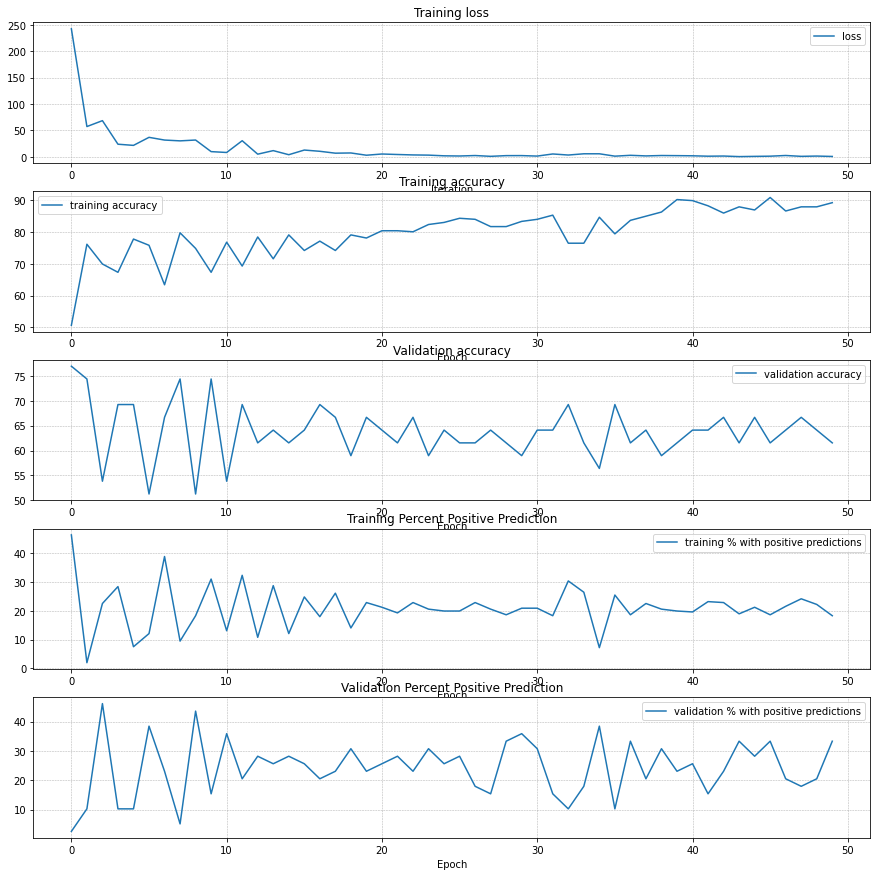

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized

In [41]:
input_size = 38 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=50)

Epoch 0, loss = 80.2325, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = 76.5439, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 54.1279, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 3, loss = 56.6476, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 4, loss = 76.6199, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 5, loss = 81.6496, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 6, loss = 47.6125, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = 68.3773, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 8, loss = 60.9482, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 9, loss = 54.9886, train_acc = 77.4510, val_acc = 79.4872, train_pos = 0.000

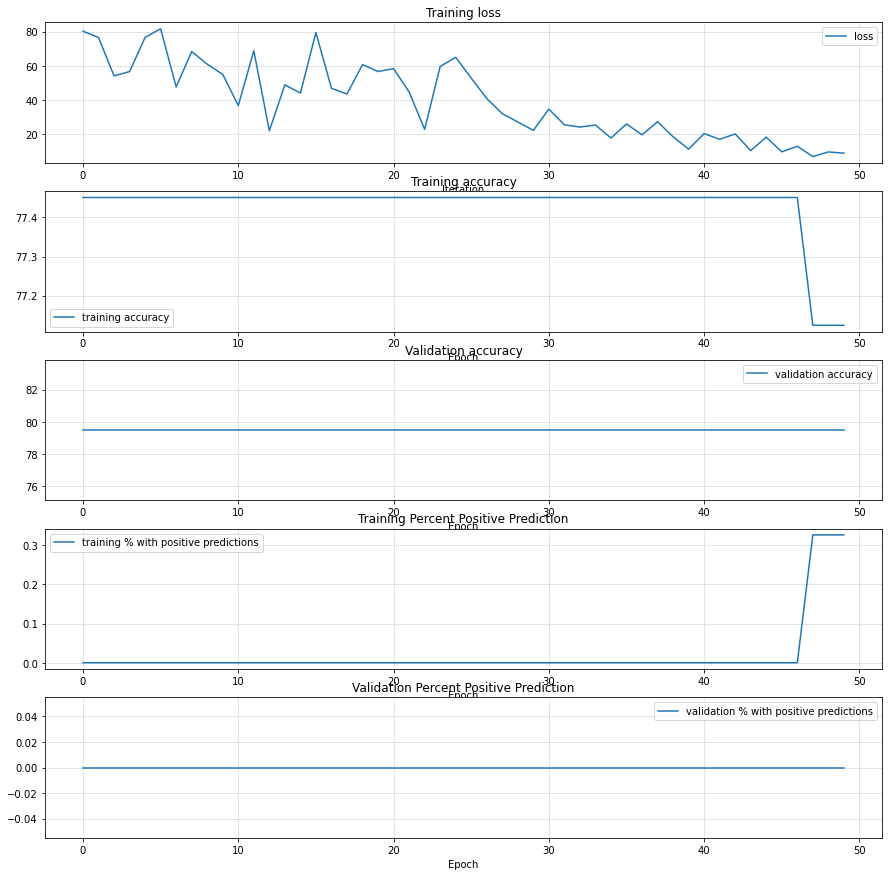

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized, oversampled

In [43]:
train_manual = df_manual.iloc[:NUM_TRAIN+NUM_VAL]

index_0 = train_manual.index[train_manual['OA_check'] == 0.0].tolist()
class_0 = train_manual.loc[index_0]
index_1 = train_manual.index[train_manual['OA_check'] == 1.0].tolist()
class_1 = train_manual.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_m_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_m_over = train_m_over.sample(frac = 1)

NUM_TRAIN_M_OS = len(train_m_over)

train_m = CustomDataset(dataframe=train_m_over)
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_M_OS)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

input_size = 38 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=100)

Epoch 0, loss = 8.6133, train_acc = 48.6940, val_acc = 69.2308, train_pos = 48.3209, val_pos = 10.2564
Epoch 1, loss = 6.0607, train_acc = 48.8806, val_acc = 35.8974, train_pos = 44.7761, val_pos = 53.8462
Epoch 2, loss = 7.6553, train_acc = 49.2537, val_acc = 58.9744, train_pos = 41.4179, val_pos = 20.5128
Epoch 3, loss = 4.0673, train_acc = 52.6119, val_acc = 41.0256, train_pos = 42.1642, val_pos = 48.7179
Epoch 4, loss = 5.7805, train_acc = 52.0522, val_acc = 53.8462, train_pos = 39.3657, val_pos = 25.6410
Epoch 5, loss = 3.4420, train_acc = 53.9179, val_acc = 51.2821, train_pos = 47.5746, val_pos = 28.2051
Epoch 6, loss = 3.1950, train_acc = 54.8507, val_acc = 48.7179, train_pos = 39.9254, val_pos = 51.2821
Epoch 7, loss = 1.7717, train_acc = 54.6642, val_acc = 56.4103, train_pos = 46.0821, val_pos = 33.3333
Epoch 8, loss = 5.9980, train_acc = 58.0224, val_acc = 51.2821, train_pos = 52.4254, val_pos = 43.5897
Epoch 9, loss = 2.2163, train_acc = 58.5821, val_acc = 51.2821, train_pos

Epoch 81, loss = 0.7623, train_acc = 64.1791, val_acc = 64.1026, train_pos = 44.4030, val_pos = 20.5128
Epoch 82, loss = 1.7623, train_acc = 63.0597, val_acc = 66.6667, train_pos = 41.0448, val_pos = 28.2051
Epoch 83, loss = 0.7560, train_acc = 62.6866, val_acc = 64.1026, train_pos = 43.2836, val_pos = 20.5128
Epoch 84, loss = 1.3998, train_acc = 61.5672, val_acc = 64.1026, train_pos = 38.0597, val_pos = 30.7692
Epoch 85, loss = 1.0209, train_acc = 64.3657, val_acc = 64.1026, train_pos = 43.4701, val_pos = 35.8974
Epoch 86, loss = 2.2630, train_acc = 63.2463, val_acc = 66.6667, train_pos = 44.2164, val_pos = 28.2051
Epoch 87, loss = 0.5818, train_acc = 61.7537, val_acc = 69.2308, train_pos = 41.6045, val_pos = 30.7692
Epoch 88, loss = 0.7369, train_acc = 62.5000, val_acc = 66.6667, train_pos = 34.1418, val_pos = 33.3333
Epoch 89, loss = 0.9457, train_acc = 63.6194, val_acc = 66.6667, train_pos = 43.4701, val_pos = 23.0769
Epoch 90, loss = 0.7757, train_acc = 61.7537, val_acc = 69.2308,

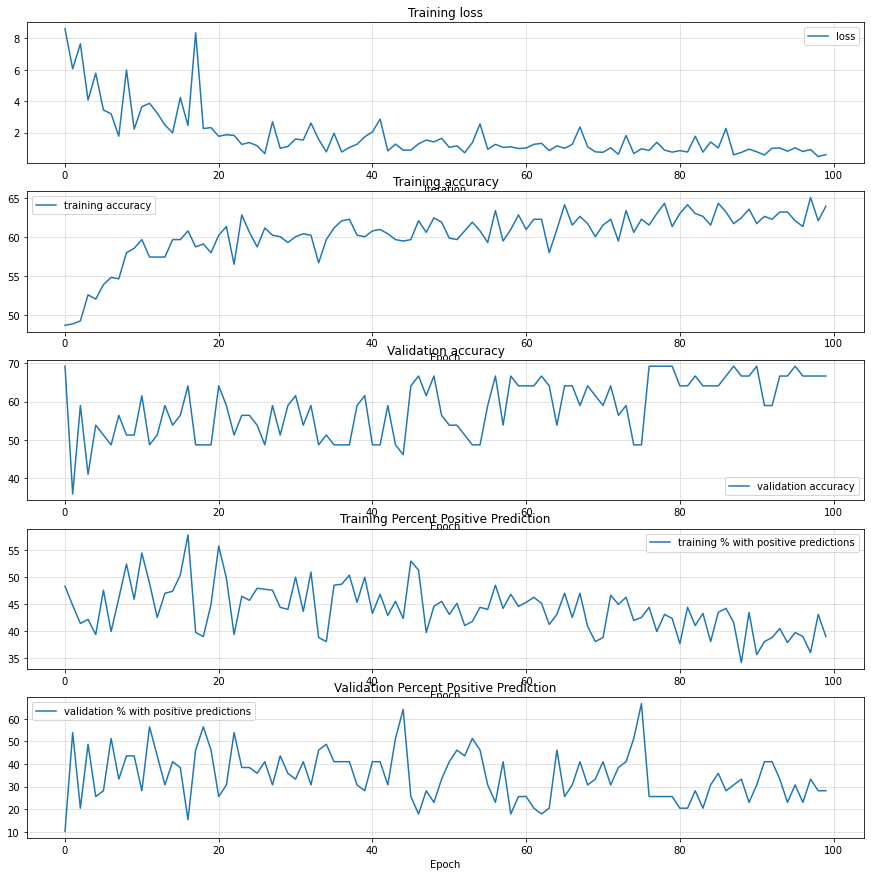

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()